# Homework 05 - Sebastiano Zagatti

In [2]:
!pip install pyro-ppl

import os
import sys
import json
import numpy as np
import torch
torch.set_default_dtype(torch.float64)

import sklearn
from sklearn.datasets import make_circles
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process as gp_sklearn

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import pyro.contrib.gp as gp

import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's consider a binary classification problem on Circles dataset. The input is two-dimensional and the response is binary
$(0,1)$.

We observe 1000 points $x$ from this dataset and their labels $y$:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


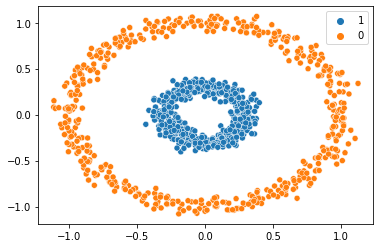

In [3]:
x, y = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
x = torch.from_numpy(x)
y = torch.from_numpy(y).double()

def scatterplot(x, y):
    colors = np.array(['0', '1'])
    sns.scatterplot(x[:, 0], x[:, 1], hue=colors[y.int()])

scatterplot(x, y)

## scikit-learn: GaussianProcessClassifier

1. `GaussianProcessClassifier` from scikit-learn library approximates the non-Gaussian posterior by a Gaussian using Laplace approximation. Define an RBF kernel `gp_sklearn.kernels.RBF` with lenghtscale parameter $= 1$ and fit a Gaussian Process classifier to the observed data $(x,y)$.

In [4]:
RBF = gp_sklearn.kernels.RBF(length_scale = 1.0)
GPC = GaussianProcessClassifier(kernel = RBF, random_state = 0)

fitted_GPC = GPC.fit(x, y)

2. Use `plot_sklearn_predictions` function defined below to plot the posterior predictive mean function over a finite grid of points. You should pass as inputs the learned GP classifier `sklearn_gp_classifier` , the observed points $x$ and their labels $y$.

In [5]:
def meshgrid(x, n, eps=0.1):
    x0, x1 = np.meshgrid(np.linspace(x[:, 0].min()-eps, x[:, 0].max()+eps, n),
                         np.linspace(x[:, 1].min()-eps, x[:, 1].max()+eps, n))
    x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    return x0, x1, x_grid

def plot_sklearn_predictions(sklearn_gp_classifier, x, y):
    x0, x1, x_grid = meshgrid(x, 30)
    preds = sklearn_gp_classifier.predict_proba(x_grid)
    preds_0 = preds[:,0].reshape(x0.shape)
    preds_1 = preds[:,1].reshape(x0.shape)
    plt.figure(figsize=(10,6))
    plt.contourf(x0, x1, preds_0, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.contourf(x0, x1, preds_1, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


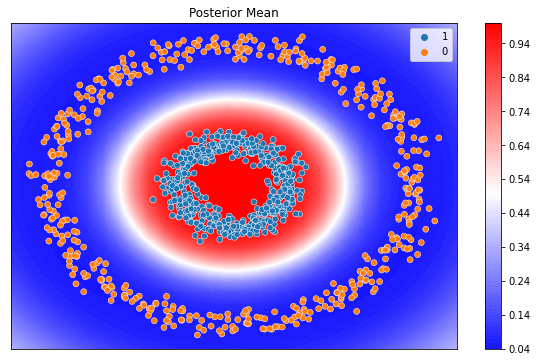

In [6]:
plot_sklearn_predictions(GPC, x, y)

## scikit-learn: GaussianProcessClassifier
Consider the following generative model:

$$y_n | p_n \sim \text{Bernoulli($p_n$)} \hspace{1cm} n = 1, \dots, N$$
$$\mu \sim \mathcal{N}(0,1)$$
$$\sigma, l \sim LogNormal(0,1)$$
$$\text{logit}(\mathbf{p})|\mu, \sigma, l \sim \mathcal{GP}\left(\mu, K_{\sigma, t}(x_n)\right)$$

We model the binary response variable with a Bernoulli likelihood. The logit of the probability is a Gaussian Process with predictors $x_n$ and kernel matrix $K_{\sigma, l}$, parametrized by variance $\sigma$ and lengthscale $l$.

We want to solve this binary classification problem by means of HMC inference, so we need to reparametrize the multivariate Gaussian $\mathcal{GP}\left( \mu, K_{\sigma, l}(x_n) \right)$ in order to ensure computational efficiency. Specifically, we model the logit
probability as:
$$\text{logit}(\mathbf{p})=\mu\cdot\mathbf{1}_N + \eta \cdot L$$
where $L$ is the Cholesky factor of $K_{\sigma, l}$ and $\eta_n \sim \mathcal{N}(0,1)$. This relationship is implemented by the `get_logits` function below.

In [7]:
def get_logits(x, mu, sigma, l, eta):
    kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(sigma), lengthscale = torch.tensor(l))
    K = kernel.forward(x, x) + torch.eye(x.shape[0]) * 1e-6
    L = K.cholesky()
    return mu+torch.mv(L,eta)

3. Write a pyro model `gp_classifier(x,y)` that implements the reparametrized generative model, using `get_logits` function and `pyro.plate` on independent observations $y_n$.

In [8]:
def gp_classifier(x, y):
    mu = pyro.sample("mu", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1))
    l = pyro.sample("l", dist.LogNormal(0, 1))
    with pyro.plate('i', len(x)):
        eta = pyro.sample("eta", dist.Normal(0, 1))
        logit_p = get_logits(x, mu, sigma, l, eta)
        y = pyro.sample("y", dist.Bernoulli(torch.sigmoid(logit_p)), obs = y)

4.  Use pyro `NUTS` on the `gp_classifier` model to infer the posterior distribution of its parameters. Set `num_samples=10` and `warmup_steps=50` . Then extract the posterior samples using pyro `.get_samples()` and print the keys of this dictionary using `.keys()` method.

In [10]:
kernel = NUTS(gp_classifier)
mcmc = MCMC(kernel, warmup_steps=50, num_samples=10, num_chains = 3) 
mcmc.run(x, y)

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=3 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu
Warmup:   0%|          | 0/60 [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Sample [2]: 100%|██████████| 60/60 [58:09, 58.15s/it, step size=2.22e-03, acc. prob=0.665]


In [11]:
samples = mcmc.get_samples()
samples.keys()

dict_keys(['eta', 'l', 'mu', 'sigma'])

The `posterior_predictive` function below outputs the prediction corresponding to the $i$-th sample from the posterior
distribution. `plot_pyro_predictions` calls this method to compute the average prediction on each input point and
plots the posterior predictive mean function over a finite grid of points.

In [12]:
def posterior_predictive(samples, i, x, x_grid):
  kernel = gp.kernels.RBF(input_dim=2, variance=samples['sigma'][i],
                          lengthscale=samples['l'][i])
  N_grid = x_grid.shape[0]
  
  y = get_logits(x, samples['mu'][i], samples['sigma'][i],
                 samples['l'][i], samples['eta'][i])
  
  with torch.no_grad():
    gpr = gp.models.GPRegression(x, y, kernel=kernel)
    mean, cov = gpr(x_grid, full_cov=True)
    
    yhat = dist.MultivariateNormal(mean, cov + torch.eye(N_grid) * 1e-6).sample()
    return yhat.sigmoid().numpy()

def plot_pyro_predictions(posterior_samples, x):
  n_samples = posterior_samples['sigma'].shape[0]
  x0, x1, x_grid = meshgrid(x, 30)
  x_grid = torch.from_numpy(x_grid)
  preds = np.stack([posterior_predictive(posterior_samples, i, x, x_grid) for i in range(n_samples)])
  plt.figure(figsize=np.array([10, 6]))
  plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101,
               cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
  plt.title(f'Posterior Mean')
  plt.xticks([]); plt.yticks([])
  plt.colorbar()
  scatterplot(x, y)

5. Pass the learned posterior samples obtained from `NUTS` inference and the set of training points $x$ to `plot_pyro_predictions` and plot the posterior predictive mean.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


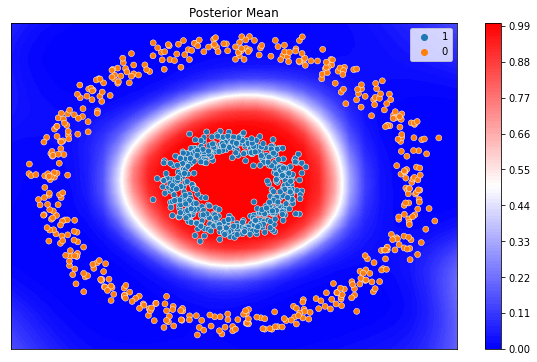

In [13]:
plot_pyro_predictions(samples, x)